Recapitulating the model: Receptor downregulation and desensitization enhance the information processing ability of signalling receptors

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
from scipy.integrate import odeint # import the ODE solver

The intial EGFR Model

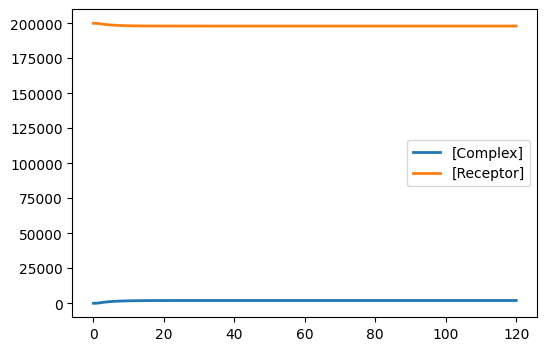

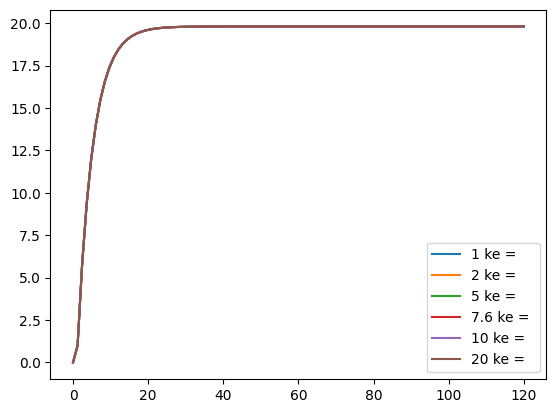

In [31]:
# seperate ligand and receptor entire EGFR model
shankaran_model_EGFR = te.loada("""

Complex -> Receptor; koff*Complex

Complex -> Ligand; koff*Complex*(1/(Nav*V))
 
$Ligand + Receptor -> Complex; Ligand*Receptor*kon

Receptor = Rt
Complex = 0

kon = 0.097
koff = 0.24
Kd = koff/kon
kt = 0.02
ke = 0.15
Rt = 2e5
Vr = kt*Rt 

Nav = 6.022*10^23
V = 4e-10
sys_corr = (1/(Nav*V))

at (time > 1): $Ligand = 0.01*Kd
""")
shankaran_model_EGFR.reset()
m = shankaran_model_EGFR.simulate(0, 120, 100)
shankaran_model_EGFR.plot()

# change a species value to recreate the graph
shankaran_model_EGFR.resetAll()

for i in [1,2,5,7.6,10,20]: 
    shankaran_model_EGFR.resetToOrigin()
    shankaran_model_EGFR.ke = 0.15*i
    result = shankaran_model_EGFR.simulate(0, 120, 100,['time','Complex'])
    plt.plot(result[:,0],result[:,1]/100, label = '%s ke = '%i) 

plt.legend()
plt.show()


The GPCR Model

The paper mentioned 10612 ligand(L) molecules were added
which is exactly 10612/(Nav*V) = 4.405e-11
L = 0.01*Kd = 4.4047e-11

R = RT, the actual value is RT/(Nav*V)  because they are 5.5e4 molecules in the system
G = 5.5e4/(6.02214e23*4e-10) 

Therefore
G = GT, G = 1e5/(6.02214e23*4e-10) 

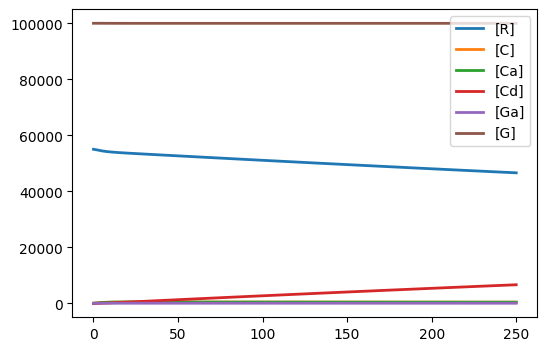

26.12994754042062
25.683691642272233
22.0050828639049
9.173432396767087
1.3812045106690574


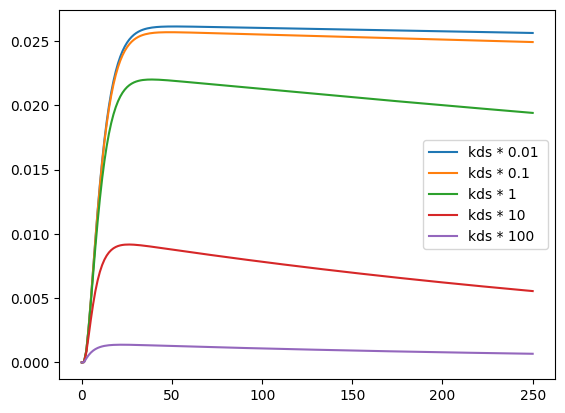

In [32]:
# seperate ligand and receptor GPCR
shankaran_model_GPCR = te.loada(""" 
$L + R -> C; L*R*kon
C -> R; C*koff
C -> L; C*koff*(1/(Nav*V))

C -> Ca; C*kfr
Ca -> C; Ca*krr

Ca -> Cd; Ca*kds

Ga -> G; Ga*ki
G -> Ga; G*ka
Ca + G -> Ga; ka*G*Ca

R = RT
G = GT
C = 0
Ca = 0
Cd = 0
Ga = 0

kon = 8.4e7
koff = 0.37
Kd = koff/kon
kfr = 10
krr = 10
kds = 0.065
ka = 1e-7
ki = 2e-1

Nav = 6.022e23
V = 4e-10
RT = (5.5e4)
GT = (1e5)

at (time > 1): $L = 0.01*Kd
""")
shankaran_model_GPCR.resetToOrigin()
GPCR_model = shankaran_model_GPCR.simulate(0,250,100)
shankaran_model_GPCR.plot()

shankaran_model_GPCR.resetAll()
for i in [10**-2, 10**-1, 10**0, 10**1, 10**2]:
    shankaran_model_GPCR.resetToOrigin()
    shankaran_model_GPCR.kds = 0.065*i
    result = shankaran_model_GPCR.simulate(0, 250, 200,['time','Ga'])
    print(max(result[:,1]))
    plt.plot(result[:,0],result[:,1]/1000, label = 'kds * %s ' %i)


plt.legend()
plt.show()

Using an ODE solver

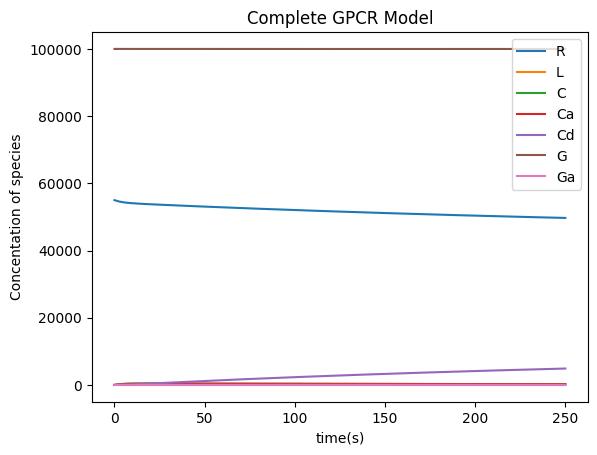

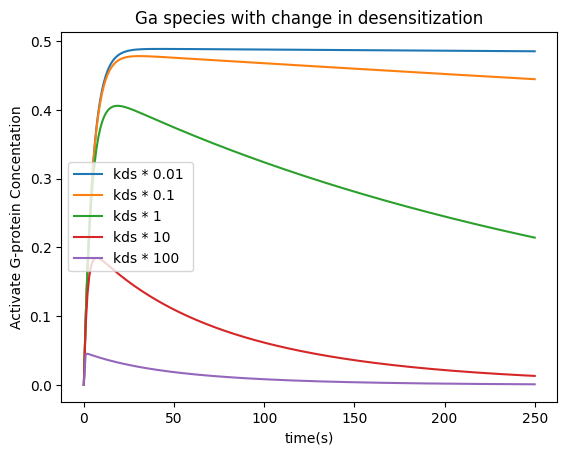

In [33]:
#The GPCR Model with differential eq.
# seperate ligand and receptor GPCR

# funtction that returns dX/dt
def model(X, t, kds = 0.065):
    
    # parameters
    kon = 8.4e7
    koff = 0.37
    Kd = koff/kon
    kfr = 10
    krr = 10
    ka = 1e-7
    ki = 2e-1
    Nav = 6.022e23
    V = 4e-10

    # mathematical form of the model
    R = X[0]
    L = X[1]
    C = X[2]
    Ca = X[3]
    Cd = X[4]
    G = X[5]
    Ga = X[6]
    ft = 0.01*Kd

    dRdt = -kon*R*L + koff*C
    dLdt = (-kon*R*L + koff*C)/(Nav*V) + ft*0
    dCdt = kon*R*L - koff*C - kfr*C + krr*Ca
    dCadt = kfr*C - krr*Ca - kds*Ca
    dCddt = kds*Ca
    dGdt = -ka*G*Ca + ki*Ga
    dGadt = ka*G*Ca - ki*Ga

    return [dRdt, dLdt, dCdt, dCadt, dCddt, dGdt, dGadt]

# Inital conidtions
kon = 8.4e7
koff = 0.37
Kd = koff/kon
L = 0.01*Kd
Nav = 6.022e23
V = 4e-10

RT = (5.5e4) 
GT = (1e5) 
R = RT
G = GT
C = 0
Ca = 0
Cd = 0
Ga = 0

IC = [R, L, C, Ca, Cd, G, Ga]

# simulation time points
t = np.linspace(0,250,250)

# solve ODE
results = odeint(model, IC, t)

plt.plot(t,results)
plt.xlabel('time(s)')
plt.ylabel('Concentation of species')
plt.legend(['R', 'L', 'C', 'Ca', 'Cd', 'G', 'Ga'])
plt.title('Complete GPCR Model')
plt.show()

kds =0.065
for mag in [10**-2, 10**-1, 10**0, 10**1, 10**2]:
    results0 = odeint(model, IC, t, args = (kds*mag,))
    plt.plot(t,results0[:,IC.index(Ga)]/1000,label = 'kds * %s ' % mag)

plt.legend()    
plt.xlabel('time(s)')
plt.ylabel('Activate G-protein Concentation')
plt.title('Ga species with change in desensitization')
plt.show()